# Example ADM analysis
Recently, we've revamped the python code for CDH Tools, this notebook aims to demonstrate the different features and uses of the main functions.

In general, there are now three main files of importance:
- cdh_utils.py: provides tools for importing data from ADM Datamart dumps
- ADMDatamart.py: provides the main class for processing the ADM Snapshot data
- plots.py: provides the plotting functions for creating visualisations

Because ADMDatamart and plots are now separate files and separate classes, it is relatively straightforward to implement new visualisations, as they just need to be added to the plots file. 

In the revamped version, cdh_utils has more convenience functions for importing data and is much faster by utilizing pyarrow or pandas directly, without having to export the zip folder into a temporary folder and then reading the data as a text file. It also now automatically detects the correct files (in most instances), and imports the latest ones, making it even easier to get started analyzing the datamart dump. 

ADMDatamart is the class that orchestrates everything: from importing the data to including the visualisations. Therefore that is the only import required. It does have some dependencies:
- pandas
- numpy
- matplotlib
- seaborn

And one optional dependency for faster dataset reading speed:
- pyarrow

The newer version of CDH Tools is tested on python version 3.8 but should work from python version 3.6 and up.

See this notebook for an introduction to the new ADMDatamart class to get an overview of the currently implemented features in the Python version of CDH Tools. If you have any suggestions for new features, please do not hesitate to raise an issue in Git, or even better: create a pull request yourself!

## Reading the data
Reading the data is quite simple. All you need to do is to give a directory location to the ADMSnapshot class and it will automatically detect the latest files and import them. There is also a default function to import the CDH Sample data directly from the internet, as you can see below:

In [2]:
import sys
import pandas as pd
pd.options.plotting.backend='plotly'
sys.path.append("../..")
from python import ADMDatamart, datasets

CDHSample = datasets.CDHSample()

File found through URL
Importing: https://raw.githubusercontent.com/pegasystems/cdh-datascientist-tools/master/data/Data-Decision-ADM-ModelSnapshot_pyModelSnapshots_20210526T131808_GMT.zip
File found through URL
Importing: https://raw.githubusercontent.com/pegasystems/cdh-datascientist-tools/master/data/Data-Decision-ADM-PredictorBinningSnapshot_pyADMPredictorSnapshots_20210526T133622_GMT.zip


As you can see, it prints out any file names that it imports. These are the two files we want: the model information (modelData) and predictor binning information (predictorData). If the function cannot find the files, it will tell you, and you can override the file names as such (which of course doesn't work here as it found them correctly by itself):

In [3]:
from pathlib import Path
Sample_not_found = ADMDatamart(f"{Path.home()}/Downloads/CDHSample",
                        model_filename = 'models.csv',
                        predictor_filename = 'binning.csv')

File models.csv not found in dir /Users/kass1/Downloads/CDHSample
File binning.csv not found in dir /Users/kass1/Downloads/CDHSample
Could not be combined. Do you have both model data and predictor data?


By default, it tries to import both model data and predictor data, and if it finds both types of data it combines them into combinedData, which is a third dataframe. 

It also automatically takes care of variable renaming and capitalization in the same way that the R version does. 

You can also supply custom mapping for variable names if they are changed in the source data for some reason by suppling a dictionary with 'VariableName':'ChangedVariableName', such as 'Performance':'AUC' if performance were somehow renamed to AUC in some ETL pipeline for example. This way you can also include variables which are not included by default if needed. 

Let's take a look at what our dataframes look like now:

In [4]:
print(CDHSample.modelData.shape)
print(CDHSample.predictorData.shape)
print(CDHSample.combinedData.shape)

(1047, 12)
(70735, 19)
(4865, 30)


Hopefully this already intuitively shows what the combinedData does: it merges the predictor binning information with extra information about the models, such as their name and Issue/Group/Channel/Direction information. Let's check them out.

In [5]:
CDHSample.modelData.head(5)

,ModelID,Issue,Group,Channel,Direction,ModelName,Positives,Configuration,ResponseCount,SnapshotTime,Performance,SuccessRate
0,5ca51e1e-49f0-58d2-8ab7-4a0ccbb326fd,Sales,DepositAccounts,SMS,Outbound,RegularSaving,16,OmniAdaptiveModel,232,2021-06-01 08:23:26.789000+00:00,0.572321,0.068966
1,b216413c-8c2e-5e1b-860b-07dfc69efa69,Sales,AutoLoans,SMS,Outbound,AutoUsed36Months,19,OmniAdaptiveModel,172,2021-06-01 08:23:26.789000+00:00,0.553309,0.110465
2,cb67c091-5a81-56f4-9845-71afa9c8076e,Sales,HomeLoans,Email,Outbound,FirstMortgageFHA,0,OmniAdaptiveModel,51,2021-06-01 08:23:26.789000+00:00,0.500000,0.000000
3,ea0a225a-7d09-5d90-88f6-d0e8380d67cc,Sales,DepositAccounts,Web,Inbound,PremierChecking,137,OmniAdaptiveModel,494,2021-06-01 08:23:26.789000+00:00,0.535957,0.277328
4,a8cde9d1-c720-537c-8fb8-8c59506bddfe,Sales,CreditCards,Web,Inbound,UPlusFinGold,19,OmniAdaptiveModel,362,2021-06-01 08:23:26.789000+00:00,0.656629,0.052486


In [6]:
CDHSample.predictorData.head(5)

,ModelID,Positives,ResponseCount,SnapshotTime,PredictorName,Performance,EntryType,BinSymbol,BinIndex,BinType,BinPositives,BinNegatives,BinResponseCount,Type,BinPositivesPercentage,BinNegativesPercentage,BinResponseCountPercentage,BinPropensity,BinAdjustedPropensity
0,bd70a915-697a-5d43-ab2c-53b0557c85a0,3,1722,2021-06-01 09:34:35.797000+00:00,Customer.Prefix,0.5,Inactive,NON-MISSING,1,EQUIBEHAVIOR,3,1719,1722,symbolic,100.0,100.0,100.0,0.001742,0.002031
1,bd70a915-697a-5d43-ab2c-53b0557c85a0,3,1722,2021-06-01 09:34:35.797000+00:00,Customer.IsCustomerActive,0.5,Inactive,NON-MISSING,1,EQUIBEHAVIOR,3,1719,1722,symbolic,100.0,100.0,100.0,0.001742,0.002031
2,bd70a915-697a-5d43-ab2c-53b0557c85a0,3,1722,2021-06-01 09:34:35.797000+00:00,Customer.HealthMatter,0.5,Inactive,MISSING,1,MISSING,3,1719,1722,symbolic,100.0,100.0,100.0,0.001742,0.002031
3,bd70a915-697a-5d43-ab2c-53b0557c85a0,0,0,2021-06-01 09:34:35.797000+00:00,Customer.SSN,0.5,Inactive,NON-MISSING,1,EQUIBEHAVIOR,0,0,0,symbolic,0.0,0.0,0.0,NaN,0.500000
4,bd70a915-697a-5d43-ab2c-53b0557c85a0,3,1722,2021-06-01 09:34:35.797000+00:00,Customer.pyCountry,0.5,Inactive,NON-MISSING,1,EQUIBEHAVIOR,3,1719,1722,symbolic,100.0,100.0,100.0,0.001742,0.002031


In [7]:
CDHSample.combinedData.head(5)

,ModelID,Issue,Group,Channel,Direction,ModelName,Positives,Configuration,ResponseCount,SnapshotTime,...,BinType,BinPositives,BinNegatives,BinResponseCount,Type,BinPositivesPercentage,BinNegativesPercentage,BinResponseCountPercentage,BinPropensity,BinAdjustedPropensity
0,08ca1302-9fc0-57bf-9031-d4179d400493,Sales,Bundles,Web,Inbound,HomeOwners,609,OmniAdaptiveModel,4605,2021-06-01 13:23:26.789000+00:00,...,EQUIBEHAVIOR,41,881,922,numeric,6.73,22.05,20.02,0.044469,0.044962
1,08ca1302-9fc0-57bf-9031-d4179d400493,Sales,Bundles,Web,Inbound,HomeOwners,609,OmniAdaptiveModel,4605,2021-06-01 13:23:26.789000+00:00,...,EQUIBEHAVIOR,10,206,216,numeric,1.64,5.16,4.69,0.046296,0.048387
2,08ca1302-9fc0-57bf-9031-d4179d400493,Sales,Bundles,Web,Inbound,HomeOwners,609,OmniAdaptiveModel,4605,2021-06-01 13:23:26.789000+00:00,...,EQUIBEHAVIOR,31,567,598,numeric,5.09,14.19,12.99,0.051839,0.052588
3,08ca1302-9fc0-57bf-9031-d4179d400493,Sales,Bundles,Web,Inbound,HomeOwners,609,OmniAdaptiveModel,4605,2021-06-01 13:23:26.789000+00:00,...,EQUIBEHAVIOR,7,115,122,numeric,1.15,2.88,2.65,0.057377,0.060976
4,08ca1302-9fc0-57bf-9031-d4179d400493,Sales,Bundles,Web,Inbound,HomeOwners,609,OmniAdaptiveModel,4605,2021-06-01 13:23:26.789000+00:00,...,EQUIBEHAVIOR,30,368,398,numeric,4.93,9.21,8.64,0.075377,0.076441


In the background we've already calculated some additional information, such as the model success rate and the bin propensities. Before getting to the visualisations, there are some more tricks: for instance, sometimes we're not interested in analyzing multiple snapshots, but only in the last known snapshot for each model/predictor. For this, there is a built-in 'last' function:

In [8]:
CDHSample.last('modelData').shape

(70, 11)

From +-1000 to 70 models in the data, so that works. Naturally we can also do the same thing for predictor data, although predictor data typically does not store multiple versions. Another thing we can try is to directly filter our data to only select values from a certain timestamp. Let's first look at the available timestamps by plotting them (showing we have multiple timestamps).

In [9]:
CDHSample.modelData.SnapshotTime

0      2021-06-01 08:23:26.789000+00:00
1      2021-06-01 08:23:26.789000+00:00
2      2021-06-01 08:23:26.789000+00:00
3      2021-06-01 08:23:26.789000+00:00
4      2021-06-01 08:23:26.789000+00:00
                     ...               
1042   2021-06-01 13:23:26.789000+00:00
1043   2021-06-01 13:23:26.789000+00:00
1044   2021-06-01 13:23:26.789000+00:00
1045   2021-06-01 13:23:26.789000+00:00
1046   2021-06-01 13:23:26.789000+00:00
Name: SnapshotTime, Length: 1047, dtype: datetime64[ns, UTC]

In [10]:
CDHSample.modelData.SnapshotTime.plot()

In [11]:
CDHSample._apply_query(CDHSample.modelData, query="SnapshotTime > '2021-06-01 12:00:00+00:00'").shape

(353, 12)

That reduced the number of rows from 1047 down to 353, as we would expect. This querying functionality is built into every individual plotting function, and also the main data import. If you give 'query' as an argument to either the ADMSnapshot initialization or to an individual plotting function, it will subset the data automatically. For ADMSnapshot initialization that persists over all subsequent visualisations as well. We will make heavy use of querying in this notebook.

## Visualisations
The following visualisations are currently available in the python version of CDH Tools. See the table below for which visualisations are applicable to what types of data:

| Visualisation                            | Needs model data | Needs multiple snapshots | Needs predictor data |
|------------------------------------------|------------------|--------------------------|----------------------|
| plotPerformanceSuccessRateBubbleChart    | True             | False                    | False                |
| plotPerformanceAndSuccessRateOverTime    | True             | True                     | False                |
| plotResponseCountMatrix                  | True             | True                     | False                |
| plotSuccessRateOverTime                  | True             | True                     | False                |
| plotPropositionSuccessRates               | True             | False                    | False                |
| plotScoreDistribution                    | True             | False                    | True                 |
| plotPredictorBinning                     | True             | False                    | True                 |
| plotPredictorPerformance                 | True             | False                    | True                 |
| plotPredictorPerformanceHeatmap          | True             | False                    | True                 |
| plotImpactInfluence                      | True             | False                    | True                 |


Let's quickly go over each one and what it does below. To start out with the bubble chart, which we can simply call by calling plotPerformanceSuccessRateBubbleChart with our main class.

In [12]:
plot = CDHSample.plotPerformanceSuccessRateBubbleChart()

Looks like a healthy bubble plot, but sometimes it is useful to consider only certain models in the analysis. Note that the bubble chart automatically considers only the last snapshot by default, though this is a parameter. 

To reduce the information, let's only consider models with more than 500 responses within the CreditCards group. 

In [13]:
query='ResponseCount > 500 and Group == "CreditCards"'
plot = CDHSample.plotPerformanceSuccessRateBubbleChart(query=query)

Alternatively, we could only look at the top n best performing models within our query. To do this, we need to supply a list of model IDs which we can easily extract from the data as such.

Note here the alternative querying syntax you can use, which was default in the previous version of CDH Tools: if you have a list (list) to subset a column's values with, you can simply supply a dictionary with 'column name':list to only get values in that list for that column.

In [14]:
top30ids = list(CDHSample.last(CDHSample.modelData).sort_values('Performance', ascending=False).reset_index()['ModelID'][0:30])

plot = CDHSample.plotPerformanceSuccessRateBubbleChart(query={'ModelID':top30ids})

If we want to look at the response rate and the AUC of some models over time, we can call plotPerformanceAndSuccessRateOverTime. Here, we filter a bit to limit the amount of information.

Maximum AUC across all models: 0.77


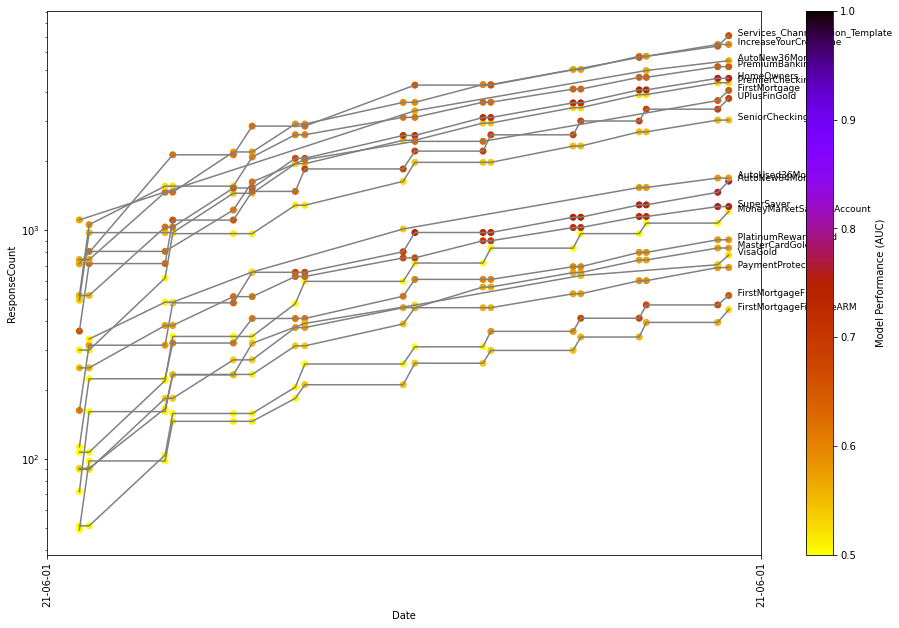

In [15]:
CDHSample.plotPerformanceAndSuccessRateOverTime(query = "Channel == 'Web'")

Similar to the responses, the success rate over time can also be of interest. With 'plotSuccessRateOverTime', you can plot the success rate of different models as they develop over time.

Pointplot generated
Modelnames generated
Setting rotations


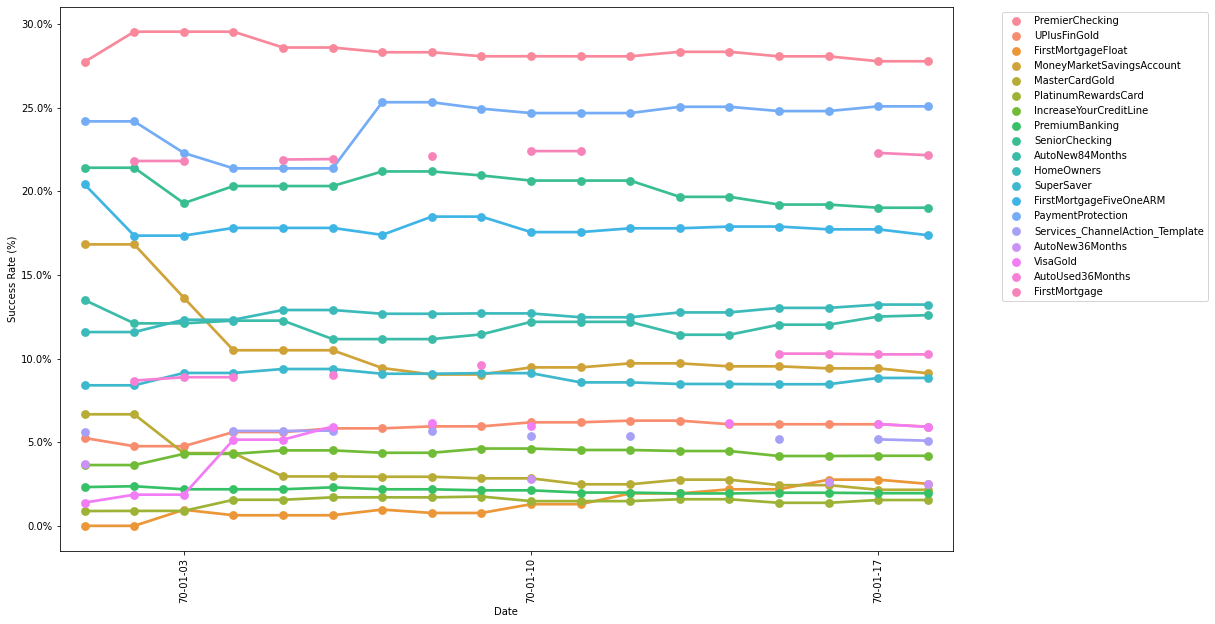

In [16]:
CDHSample.plotSuccessRateOverTime(query="Channel=='Web'")

And if it is not interesting to consider the success rate over time, there is also 'plotPropositionSuccessRates', which by default considers the last state of the models and plots the histogram of their success rates.

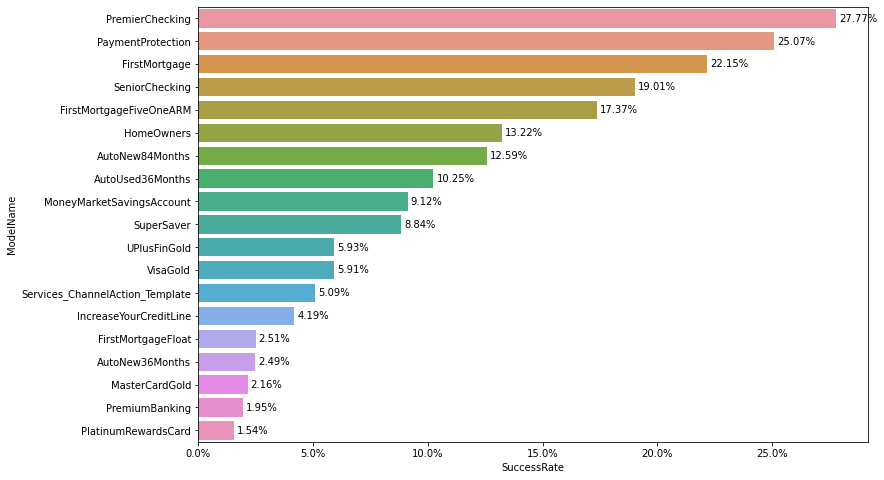

In [17]:
CDHSample.plotPropositionSuccessRates(query="Channel=='Web'")

If we want to look at the distribution of responses and their propensities for a given model, we can subset that model and call plotScoreDistribution. Note here we subset the model by its ID.

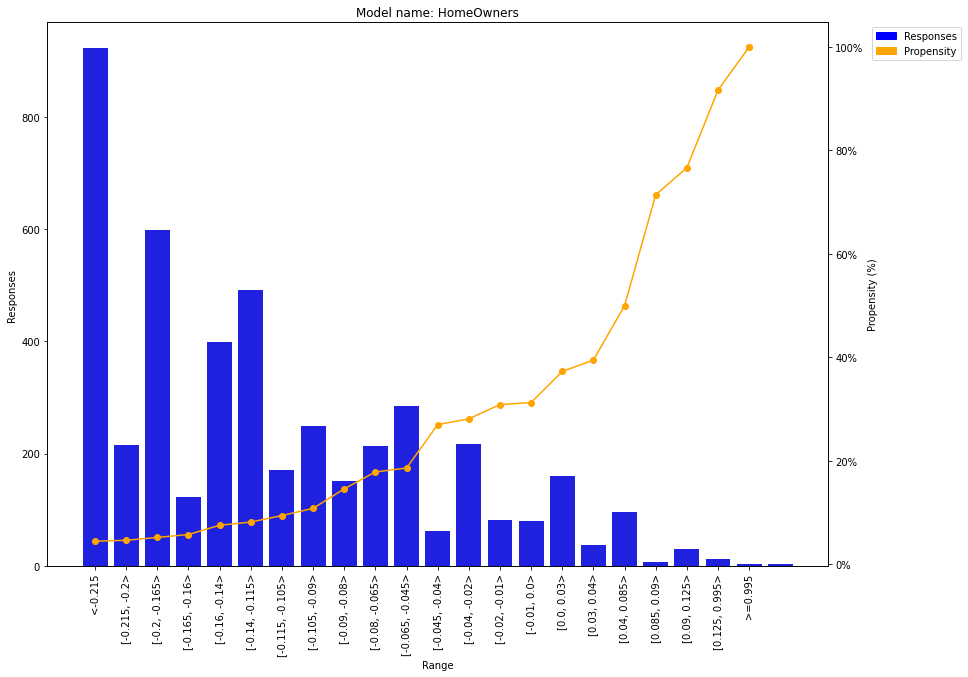

In [18]:
CDHSample.plotScoreDistribution(query='ModelID == "08ca1302-9fc0-57bf-9031-d4179d400493"')

Alternatively, we can also subset a model by its model name, and then further drill down by group/issue/channel/configuration. See the example below.

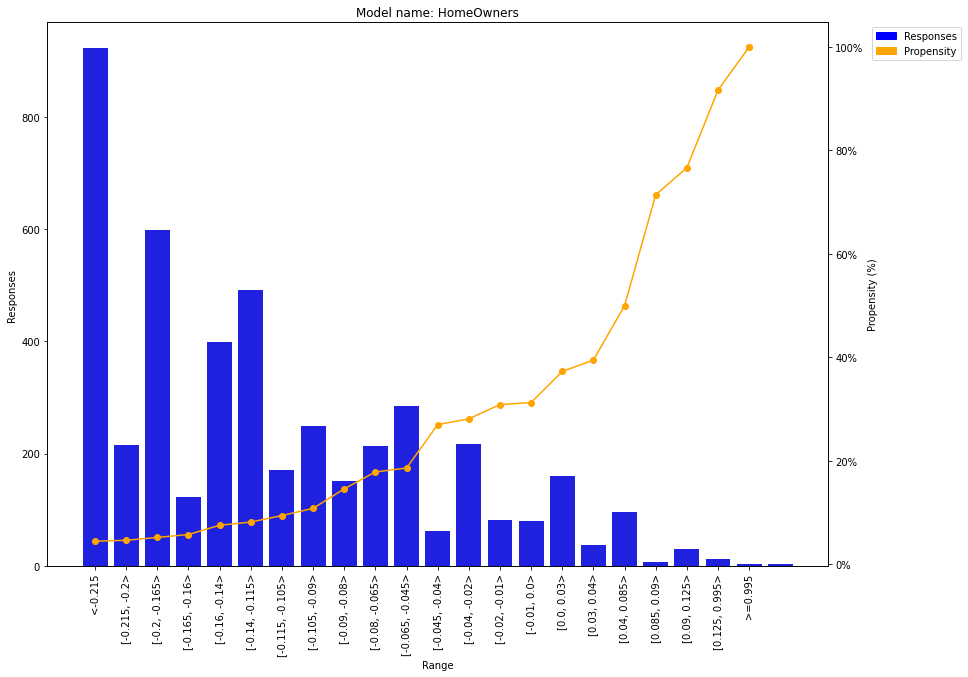

In [19]:
CDHSample.plotScoreDistribution(query='ModelName == "HomeOwners" and Group == "Bundles" and Issue == "Sales" and Channel == "Web" and Configuration == "OmniAdaptiveModel"')

Similarly, we can also display the distribution of a single predictor and its binning. This function loops through each predictor of a model and generates the binning image for that predictor. For that reason we recommend subsetting the predictor names ahead of time or, depending on how many predictors the model has, a lot of images will be generated.

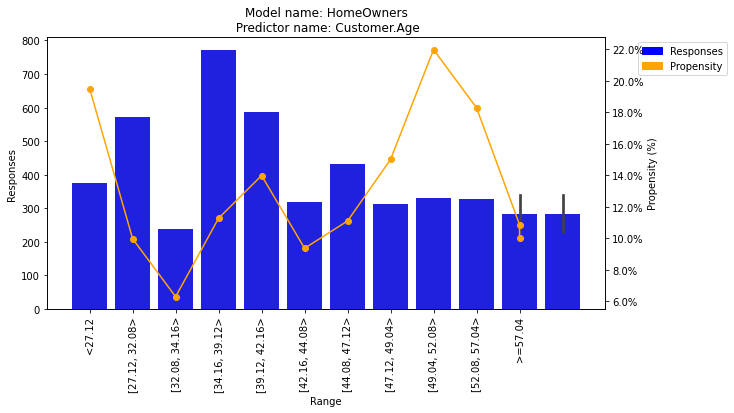

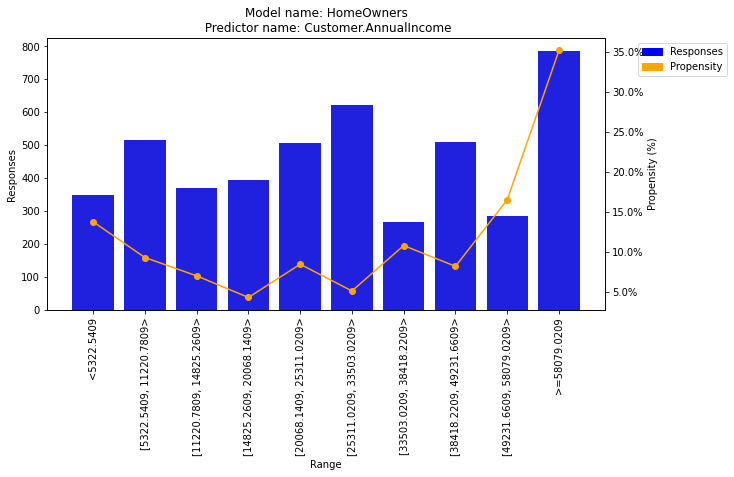

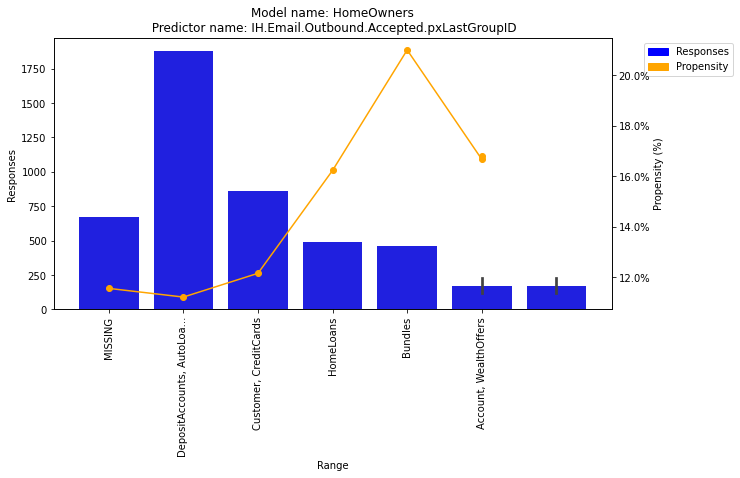

In [20]:
CDHSample.plotPredictorBinning(query=f'ModelID == "08ca1302-9fc0-57bf-9031-d4179d400493" and PredictorName in {["Customer.Age", "Customer.AnnualIncome", "IH.Email.Outbound.Accepted.pxLastGroupID"]}')

Alternatively we can look at the performance of a predictor over multiple models. Again, we recommend subsetting the predictor names with a list to make it more legible. 

In [21]:
plot = CDHSample.plotPredictorPerformance(query=f'PredictorName in {["Customer.Age", "Customer.AnnualIncome", "IH.Email.Outbound.Accepted.pxLastGroupID"]}')

What the two previous visualisations could not represent very well is the performance of the predictors over different models. That is what the plotPredictorPerformanceHeatmap function does; again with subsetting of predictors as a recommended step.

In [22]:
plot = CDHSample.plotPredictorPerformanceHeatmap(query=f'PredictorName in {["Customer.Age", "Customer.AnnualIncome", "IH.Email.Outbound.Accepted.pxLastGroupID"]}')